# Set up

In [1]:
import numpy as np
import sys
import math as m
import pickle as pickle
import pandas as pd
fmts = ['svg','pdf']
from scipy.stats import norm, wilcoxon, ttest_rel, friedmanchisquare, shapiro,f_oneway,friedmanchisquare,rankdata
import statsmodels.stats.multitest as smm
from scipy import signal, fft
from scipy.optimize import curve_fit, minimize
import scipy.interpolate as interp
from matplotlib import animation as ani # animation
import matplotlib.pyplot as plt # Matlab-style plotting
from matplotlib import rcParams
from matplotlib.lines import Line2D
from itertools import combinations

# auto reload modules
%load_ext autoreload
%autoreload 2

In [114]:
sys.path.append('C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion\\analysis\\Multimodal paper') # change this for your computer

from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *
import plotting_variables
from plotting_variables import TINY_SIZE, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE, MARKER_SIZE, python_colors, colors, yfill, ufill, gfill, rfill, bfill

In [3]:
print('data length = ',N)
print('primes = ',primes)
print('base freq = ',base_freq)
print('IX = ',IX)
print('Even_IX = ',Even_IX)
print('Odd_IX = ',Odd_IX)
print('freqs = ',freqs)
print('omegas = ',omegas)
print('T = ',T) # total time 40 seconds
print('t = ',t) # timestamps
print('fs = ',fs)
print('sample_period (dt)= ',dt)
print('xf = ',xf) # frequency domain x-axis, shape (N//2,)
print('Machine = ',M) # soM at stimulated freqs
print('scaleInput = ',scaleInput)
print('scaleOutputScreen = ',scaleOutputScreen)

data length =  2400
primes =  [ 2  3  5  7 11 13 17 19]
base freq =  0.05
IX =  [ 4  6 10 14 22 26 34 38]
Even_IX =  [ 6 14 26 38]
Odd_IX =  [ 4 10 22 34]
freqs =  [0.1  0.15 0.25 0.35 0.55 0.65 0.85 0.95]
omegas =  [0.62831853 0.9424778  1.57079633 2.19911486 3.45575192 4.08407045
 5.34070751 5.96902604]
T =  40
t =  [0.00000000e+00 1.66736140e-02 3.33472280e-02 ... 3.99666528e+01
 3.99833264e+01 4.00000000e+01]
fs =  60
sample_period (dt)=  0.016666666666666666
xf =  [0.0000e+00 2.5000e-02 5.0000e-02 ... 2.9925e+01 2.9950e+01 2.9975e+01]
Machine =  [-0.7169568 -1.14107219j -0.52958685-0.5619091j  -0.28840044-0.18360142j
 -0.17134712-0.0779164j  -0.07726649-0.02235881j -0.05656227-0.01384948j
 -0.03387172-0.00634218j -0.02730057-0.00457371j]
scaleInput =  0.04616974606700115
scaleOutputScreen =  0.25


# Load data

In [4]:
# CGANGE THIS TO YOUR OWN PATH
path = "C:\\Users\\amber\\OneDrive - UW\\Sensorimotor Fusion\\pickles\\"  # for Amber's laptop
# path = r'/Users/amberchou/Library/CloudStorage/OneDrive-UW(2)/meta/eye_tracking/pickles/pickles_11_subjects/'  # for Amber's mac

# Load the array from the file
with open(path+'multimodal_data.pkl', 'rb') as file:
    Rs,Ds,MDs,Us,U0s,U1s,Ys,rs,ds,mds,us,u0s,u1s,ys,errors,Tur,Tu0r,Tu1r,Tud,Tu0d,Tu1d,Tyr,Tyd,F,B,F0,F1,B0,B1 = pickle.load(file)

In [5]:
rs = rs.astype(float)

In [6]:
print(Rs.shape) # subject x condition x trial x all freqs
print(rs.shape) # subject x condition x trial x timestamps
print(errors.shape) # subject x condition x trial

subject_num = Rs.shape[0]
condition_num = Rs.shape[1]
trial_num = Rs.shape[2]
print('subject_num = ',subject_num)
print('condition_num (alphas) = ',condition_num)
print('trial_num = ',trial_num)
alphas = np.array([0,0.25,0.5,0.75,1])
# conditions = ['0','0.25','0.5','0.75','1']
conditions = ['0','25','50','75','100']

(15, 5, 14, 2400)
(15, 5, 14, 2400)
(15, 5, 14)
subject_num =  15
condition_num (alphas) =  5
trial_num =  14


In [7]:
def stats_test(datas):
    # Compute residuals (observed - condition mean)
    residuals_0 = datas[0] - np.mean(datas[0])
    residuals_25 = datas[1] - np.mean(datas[1])
    residuals_50 = datas[2] - np.mean(datas[2])
    residuals_75 = datas[3] - np.mean(datas[3])
    residuals_100 = datas[4] - np.mean(datas[4])

    # Combine residuals from all conditions
    all_residuals = np.concatenate([residuals_0, residuals_25, residuals_50, residuals_75, residuals_100])

    # Perform Shapiro-Wilk test on residuals
    stat, p = shapiro(all_residuals)
    print(f'Shapiro-Wilk Test Statistic={stat:.4f}, p-value={p:.4f}')
    if p > 0.05:
        print("Residuals appear to be normally distributed (fail to reject H0).")
        stat, p = f_oneway(datas[0],datas[1],datas[2],datas[3],datas[4]) #see if p < 0.05, there is a significant difference
        print(f'One-way ANOVA Statistic={stat:.4f}, p-value={p:.4f}')
    else:
        print("Residuals are NOT normally distributed (reject H0).") 
         # Perform Friedman test
        stat, p = friedmanchisquare(datas[0],datas[1],datas[2],datas[3],datas[4])
        print(f'Friedman Test Statistic={stat:.4f}, p-value={p:.4f}') # If p < 0.05, there is a significant difference
        if p <= 0.05:
            print('Friedman Test: significant difference')
            # post hoc test with Wilcoxon signed-rank tests with Bonferroni correction
            comparisons = [
                ("25 vs. 0", datas[1], datas[0]),
                ("50 vs. 0", datas[2], datas[0]),
                ("75 vs. 0", datas[3], datas[0]),
                ("25 vs. 100", datas[1], datas[4]),
                ("50 vs. 100", datas[2], datas[4]),
                ("75 vs. 100", datas[3], datas[4])
            ]
            p_values = []
            for name, cond1, cond2 in comparisons:
                stat, p = wilcoxon(cond1, cond2)
                p_values.append(p)
            # Apply Bonferroni correction (dividing α by 6)
            corrected_p_values = smm.multipletests(p_values, method='bonferroni')[1]
            for (name, _, _), p_raw, p_corr in zip(comparisons, p_values, corrected_p_values):
                print(f'{name}: Raw p-value = {p_raw:.4f}, Bonferroni-corrected p-value = {p_corr:.4f}')
        else:
            print('Friedman Test: no significant difference')

# FF (single vs. multimodal)

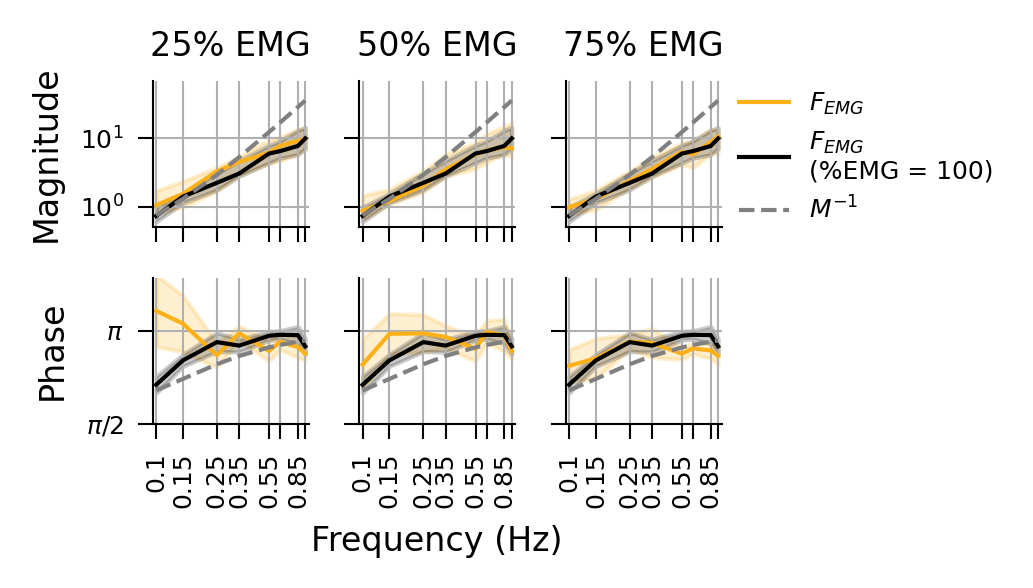

In [41]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
# xtickslabels = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xtickslabels = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, '', 0.85, ''])
xlim = (0.095, 1.0)
ylimphase = (np.pi/2, np.pi+0.9)
yticksphase = [np.pi/2,np.pi]
yticklabelsphase = [r'$\pi/2$',r'$\pi$']
last_few_trials = 5 # trial)num//2
fig,axs = plt.subplots(2,3, sharex = 'col', sharey = 'row',figsize=(3.5,2), dpi=300)
for cond in [1,2,3]:
    # F0
    F_mean = np.mean(np.abs(F0[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$F_{EMG}$',color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,cond,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F_EMG-only
    F_mean = np.mean(np.abs(F0[:,4,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$F_{EMG}$'+'\n(%EMG = 100)',color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,4,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[4],color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    ax = axs[0,cond-1]
    ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.grid('on',zorder=-1,linewidth=0.5)
    ax.set_ylim(0.5,70)
    ax.set_yscale("log")
    ax.minorticks_off()

    ax = axs[1,cond-1]
    ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$')
    ax.grid('on',zorder=-1,linewidth=0.5)
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickslabels,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.minorticks_off()

    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    axs[0,cond-1].set_title(conditions[cond]+r'% EMG') #($100*\alpha) 
# axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
axs[0,0].set_ylabel('Magnitude')
axs[1,0].set_ylabel('Phase') 
axs[1,1].set_xlabel('Frequency (Hz)')
axs[1,0].set_yticks(yticksphase)
axs[1,0].set_yticklabels(yticklabelsphase)
axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,frameon=False)
plt.tight_layout()
plt.show()

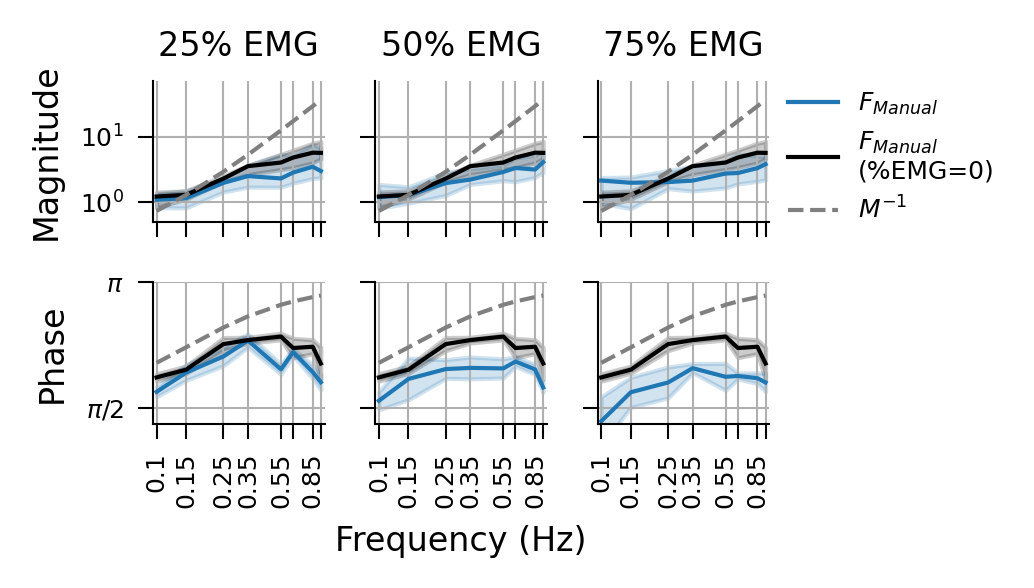

In [50]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xtickslabels = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, '', 0.85,''])
xlim = (0.095, 1.0)
ylimphase = (np.pi/2-0.2, np.pi)
yticksphase = [np.pi/2,np.pi]
yticklabelsphase = [r'$\pi/2$',r'$\pi$']
last_few_trials = 5 # trial)num//2
fig,axs = plt.subplots(2,3, sharex = 'col', sharey = 'row',figsize=(3.5,2), dpi=300)

for cond in [1,2,3]:
    # F1
    F_mean = np.mean(np.abs(F1[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$F_{Manual}$',color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,cond,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    # F_Manual-only
    F_mean = np.mean(np.abs(F[:,0,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$F_{Manual}$'+'\n(%EMG=0)',color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F[:,0,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[0],color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    ax = axs[0,cond-1]
    ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.grid('on',zorder=-1,linewidth=0.5)
    ax.set_ylim(0.5,70)
    ax.set_yscale("log")
    ax.minorticks_off()
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1,cond-1]
    ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$')
    ax.grid('on',zorder=-1,linewidth=0.5)
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickslabels,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.minorticks_off()

    # ax.set_xlabel('Frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    axs[0,cond-1].set_title(conditions[cond]+r'% EMG') #($100*\alpha) 
# axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
axs[0,0].set_ylabel('Magnitude')
axs[1,0].set_ylabel('Phase') 
axs[1,1].set_xlabel('Frequency (Hz)')
axs[1,0].set_yticks(yticksphase)
axs[1,0].set_yticklabels(yticklabelsphase)
axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,frameon=False)
plt.tight_layout()
plt.show()

# FB

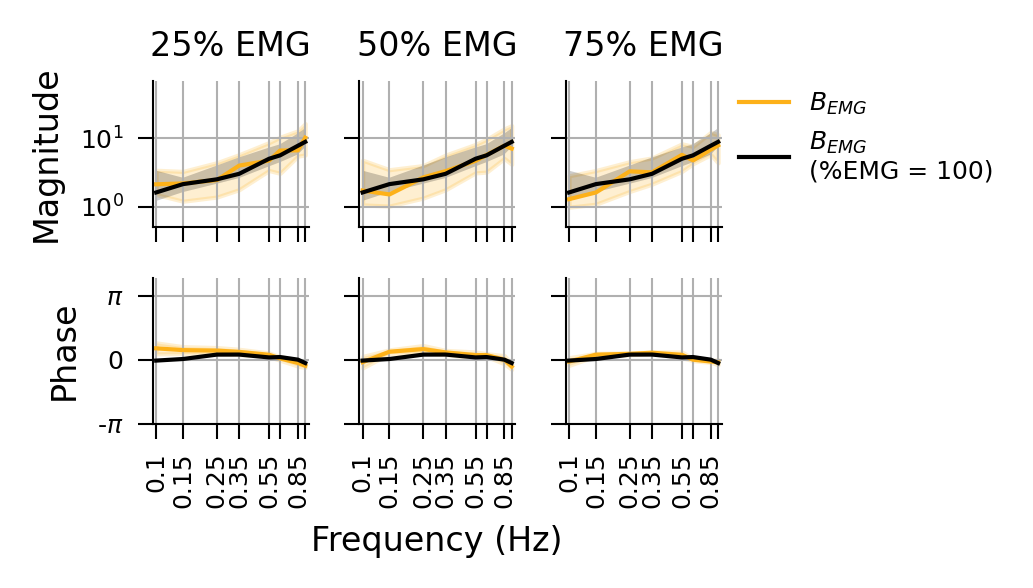

In [51]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xtickslabels = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, '', 0.85,''])
xlim = (0.095, 1.0)
ylimphase = (-np.pi, np.pi+0.9)
yticksphase = [-np.pi,0,np.pi]
yticklabelsphase = [r'-$\pi$','0',r'$\pi$']
last_few_trials = 5 # trial)num//2
fig,axs = plt.subplots(2,3, sharex = 'col', sharey = 'row',figsize=(3.5,2), dpi=300)
for cond in [1,2,3]:
    # F0
    F_mean = np.mean(np.abs(B0[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$B_{EMG}$',color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B0[:,cond,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F_EMG-only
    F_mean = np.mean(np.abs(B0[:,4,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$B_{EMG}$'+'\n(%EMG = 100)',color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black',edgecolor = None)
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B0[:,4,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[4],color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black',edgecolor = None)

    ax = axs[0,cond-1]
    ax.set_xscale("log")
    ax.grid('on',zorder=-1,linewidth=0.5)
    ax.set_ylim(0.5,70)
    ax.set_yscale("log")
    ax.minorticks_off()

    ax = axs[1,cond-1]
    ax.grid('on',zorder=-1,linewidth=0.5)
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickslabels,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.minorticks_off()

    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    axs[0,cond-1].set_title(conditions[cond]+r'% EMG') #($100*\alpha) 
# axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
axs[0,0].set_ylabel('Magnitude')
axs[1,0].set_ylabel('Phase') 
axs[1,1].set_xlabel('Frequency (Hz)')
axs[1,0].set_yticks(yticksphase)
axs[1,0].set_yticklabels(yticklabelsphase)
axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,frameon=False)
plt.tight_layout()
plt.show()

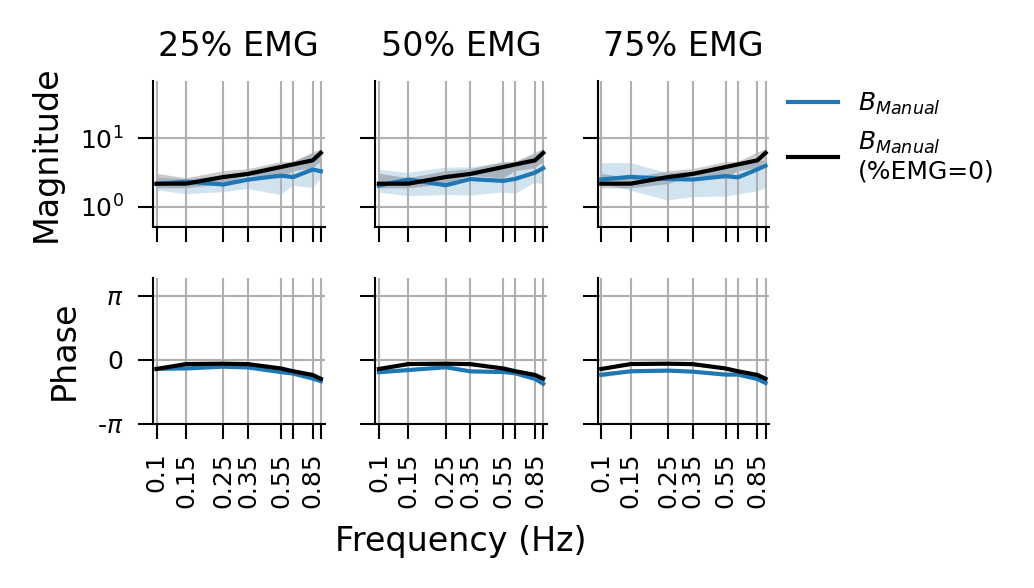

In [53]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xtickslabels = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, '', 0.85,''])
xlim = (0.095, 1.0)
ylimphase = (-np.pi, np.pi+0.9)
yticksphase = [-np.pi,0,np.pi]
yticklabelsphase = [r'-$\pi$','0',r'$\pi$']
last_few_trials = 5 # trial)num//2
fig,axs = plt.subplots(2,3, sharex = 'col', sharey = 'row',figsize=(3.5,2), dpi=300)

for cond in [1,2,3]:
    # F1
    F_mean = np.mean(np.abs(B1[:,cond,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0) #across subjects
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$B_{Manual}$',color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'],edgecolor = None)
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B1[:,cond,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'],edgecolor = None)

    # F_Manual-only
    F_mean = np.mean(np.abs(B1[:,0,-last_few_trials:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0,cond-1]
    ax.plot(freqs,q50,'-',label = r'$B_{Manual}$'+'\n(%EMG=0)',color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black',edgecolor = None)
    # phase
    ax = axs[1,cond-1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B1[:,0,-last_few_trials:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$\alpha = $'+conditions[0],color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black',edgecolor = None)

    ax = axs[0,cond-1]
    ax.set_xscale("log")
    ax.grid('on',zorder=-1,linewidth=0.5)
    ax.set_ylim(0.5,70)
    ax.set_yscale("log")
    ax.minorticks_off()
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1,cond-1]
    ax.grid('on',zorder=-1,linewidth=0.5)
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickslabels,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.minorticks_off()

    # ax.set_xlabel('Frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    axs[0,cond-1].set_title(conditions[cond]+r'% EMG') #($100*\alpha) 
# axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
axs[0,0].set_ylabel('Magnitude')
axs[1,0].set_ylabel('Phase') 
axs[1,1].set_xlabel('Frequency (Hz)')
axs[1,0].set_yticks(yticksphase)
axs[1,0].set_yticklabels(yticklabelsphase)
axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,frameon=False)
plt.tight_layout()
plt.show()

# Strategies groups

In [ ]:
# condition 2, for every trial, find F0 - F1
cond = 2
group_a = []
group_b = []
group_c = []
for sub in range(subject_num):
    F0_mean = np.mean(np.abs(F0[sub,cond,-last_few_trials//2:,:]),axis = 0) #mean across all trials
    F1_mean = np.mean(np.abs(F1[sub,cond,-last_few_trials//2:,:]),axis = 0) #mean across all trials
    F0_F1 = np.abs(F0_mean) - np.abs(F1_mean)
    if F0_F1[:3].mean() > 0 and F0_F1[3:].mean() > 0:
        group_a.append(sub)
    elif F0_F1[:3].mean() < 0 and F0_F1[3:].mean() < 0:
        group_b.append(sub)
    else:
        group_c.append(sub)

print('group_a = ',group_a) # F0 > F1 at all frequencies # EMG-led
print('group_b = ',group_b) # F0 < F1 at all frequencies #Manual-led
print('group_c = ',group_c) # mixed    

group_a =  [0, 3, 5, 7, 8, 10, 13]
group_b =  [6, 9, 12]
group_c =  [1, 2, 4, 11, 14]


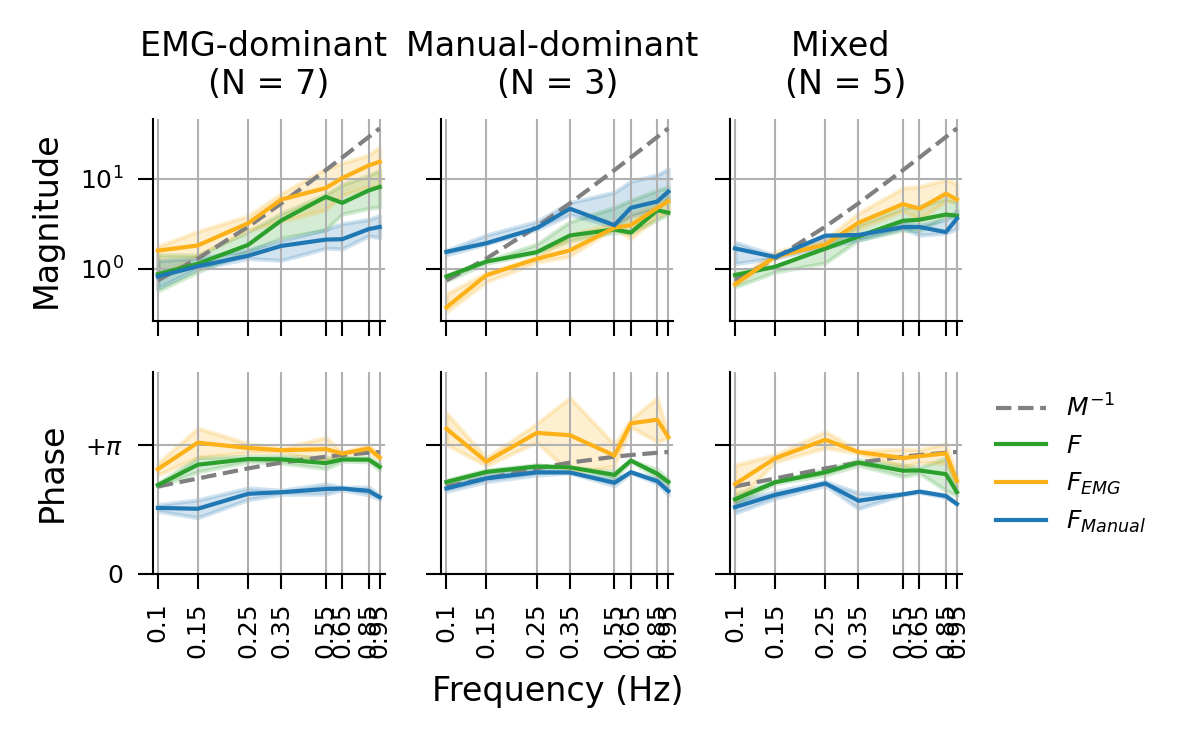

In [72]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1.8)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']
last_few_trials = 7 # cross trials (N//2)

for cond in [2]:
    fig,axs = plt.subplots(2,3,sharex = 'col', sharey = 'row',figsize=(4,2.5), dpi=300)

    for i,sub in enumerate([group_a,group_b,group_c]):
        # magnitude
        ax = axs[0,i]
        ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'Machine inverse $M^{-1}$')
        
        mean = np.mean(np.abs(F[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (combined)',color = colors['GREEN'])
        ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])

        mean = np.mean(np.abs(F0[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (EMG pathway)',color = colors['GOLD'])
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['GOLD'])

        mean = np.mean(np.abs(F1[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (Manual pathway)',color = colors['BLUE'])
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['BLUE'])

        ax.set_xscale("log")
        ax.set_xlim(xlim)
        ax.grid('on',zorder=-1)
        # ax.set_ylim(0.1,80)
        ax.set_yscale("log")
        ax.minorticks_off()
        
        # phase
        ax = axs[1,i]
        ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$')

        angle = np.angle(np.mean(np.exp(1j*(np.angle(F[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi/2
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$F$',color = colors['GREEN'])
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GREEN'])

        angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$F_{EMG}$',color = colors['GOLD'])
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

        angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi/2
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$F_{Manual}$',color = colors['BLUE'])
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

        ax.grid('on',zorder=-1)
        ax.set_ylim(ylimphase)
        ax.set_yticks(yticksphase)
        ax.set_yticklabels(yticklabelsphase)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks,rotation=90) 
        ax.minorticks_off()
    axs[1,1].set_xlabel('Frequency (Hz)')
    axs[0,0].set_ylabel('Magnitude')
    axs[1,0].set_ylabel('Phase')
    axs[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)
    axs[0,0].set_title('EMG-dominant ''\n''(N = '+str(len(group_a))+')')
    axs[0,1].set_title('Manual-dominant ''\n''(N = '+str(len(group_b))+')')
    axs[0,2].set_title('Mixed ''\n''(N = '+str(len(group_c))+')')
    # axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
    # axs[0,2].get_shared_x_axes().join(axs[0,0], axs[0,1])

    plt.tight_layout()
    plt.show()

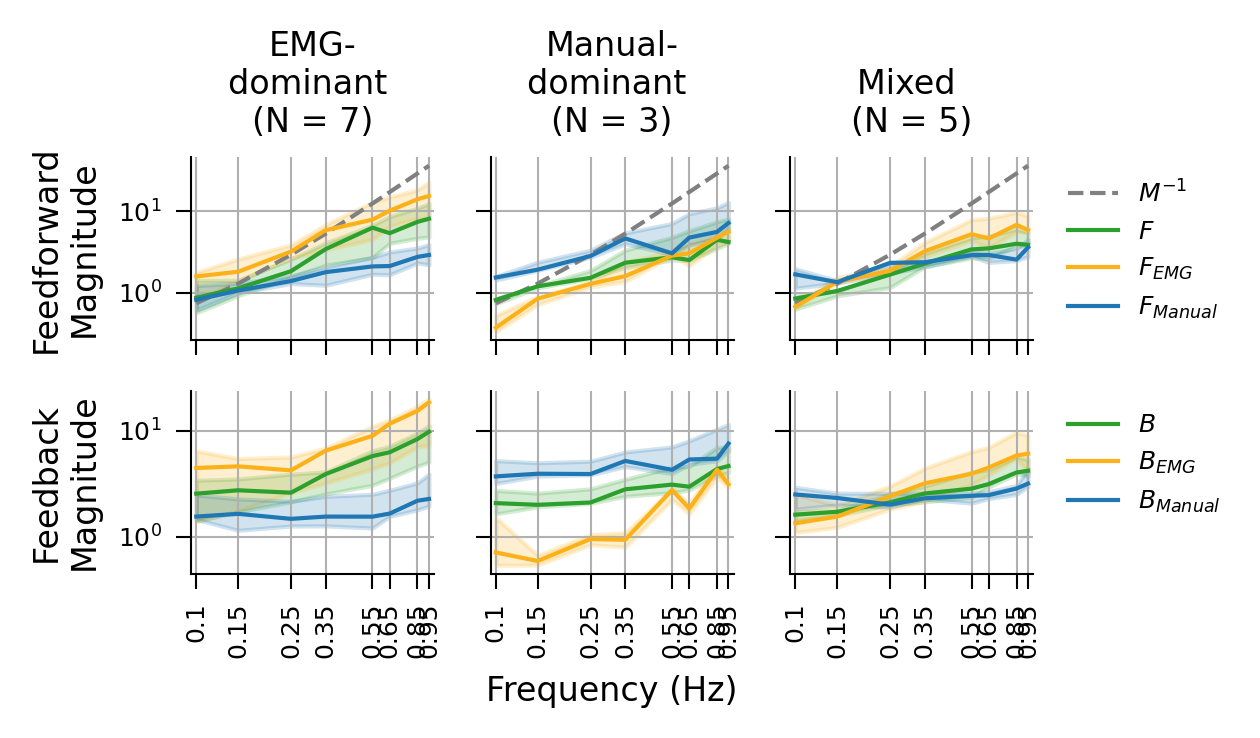

In [ ]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xtickslabels = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1.8)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']
last_few_trials = 7 # cross trials (N//2)

for cond in [2]:
    fig,axs = plt.subplots(2,3,sharex = 'col', sharey = 'row',figsize=(4.25,2.5), dpi=300)

    for i,sub in enumerate([group_a,group_b,group_c]):
        # magnitude
        ax = axs[0,i]
        ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label =r'$M^{-1}$') #'Machine\ninverse\n'
        
        mean = np.mean(np.abs(F[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = r'$F$',color = colors['GREEN'])
        ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])

        mean = np.mean(np.abs(F0[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = r'$F_{EMG}$',color = colors['GOLD'])
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['GOLD'])

        mean = np.mean(np.abs(F1[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label =r'$F_{Manual}$',color = colors['BLUE'])
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['BLUE'])

        ax.set_xscale("log")
        ax.set_xlim(xlim)
        ax.grid('on',zorder=-1)
        # ax.set_ylim(0.1,80)
        ax.set_yscale("log")
        ax.minorticks_off()
        
        # phase
        ax = axs[1,i]        
        mean = np.mean(np.abs(B[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = r'$B$',color = colors['GREEN'])
        ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])

        mean = np.mean(np.abs(B0[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = r'$B_{EMG}$',color = colors['GOLD'])
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['GOLD'])

        mean = np.mean(np.abs(B1[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label =r'$B_{Manual}$',color = colors['BLUE'])
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['BLUE'])

        ax.set_xscale("log")
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtickslabels,rotation=90)
        ax.set_xlim(xlim)
        ax.grid('on',zorder=-1)
        # ax.set_ylim(0.1,80)
        ax.set_yscale("log")
        ax.minorticks_off()
    axs[1,1].set_xlabel('Frequency (Hz)')
    axs[0,0].set_ylabel('Feedforward\nMagnitude')
    axs[1,0].set_ylabel('Feedback\nMagnitude')
    axs[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)
    axs[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)
    axs[0,0].set_title('EMG-\ndominant ''\n''(N = '+str(len(group_a))+')',fontsize=SMALL_SIZE)
    axs[0,1].set_title('Manual-\ndominant ''\n''(N = '+str(len(group_b))+')',fontsize=SMALL_SIZE)
    axs[0,2].set_title('Mixed ''\n''(N = '+str(len(group_c))+')',fontsize=SMALL_SIZE)
    # axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
    # axs[0,2].get_shared_x_axes().join(axs[0,0], axs[0,1])

    plt.tight_layout()
    plt.show()

## task performance of the 3 groups

In [122]:
last_trials = 10

subs = group_a
datas = []
for cond in range(condition_num):
    #mean across all trials and timestamps
    datas.append( np.mean((100*rs[subs,cond,-last_trials:] - 100*ys[subs,cond,-last_trials:])**2,axis = (1,2)) )
GROUP_A_RMSE = datas

subs = group_b
datas = []
for cond in range(condition_num):
    #mean across all trials and timestamps
    datas.append( np.mean((100*rs[subs,cond,-last_trials:] - 100*ys[subs,cond,-last_trials:])**2,axis = (1,2)) )
GROUP_B_RMSE = datas

subs = group_c
datas = []
for cond in range(condition_num):
    #mean across all trials and timestamps
    datas.append( np.mean((100*rs[subs,cond,-last_trials:] - 100*ys[subs,cond,-last_trials:])**2,axis = (1,2)) )
GROUP_C_RMSE = datas


C:\Users\amber\AppData\Local\Temp\ipykernel_61804\3723713933.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
C:\Users\amber\AppData\Local\Temp\ipykernel_61804\3723713933.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
C:\Users\amber\AppData\Local\Temp\ipykernel_61804\3723713933.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)


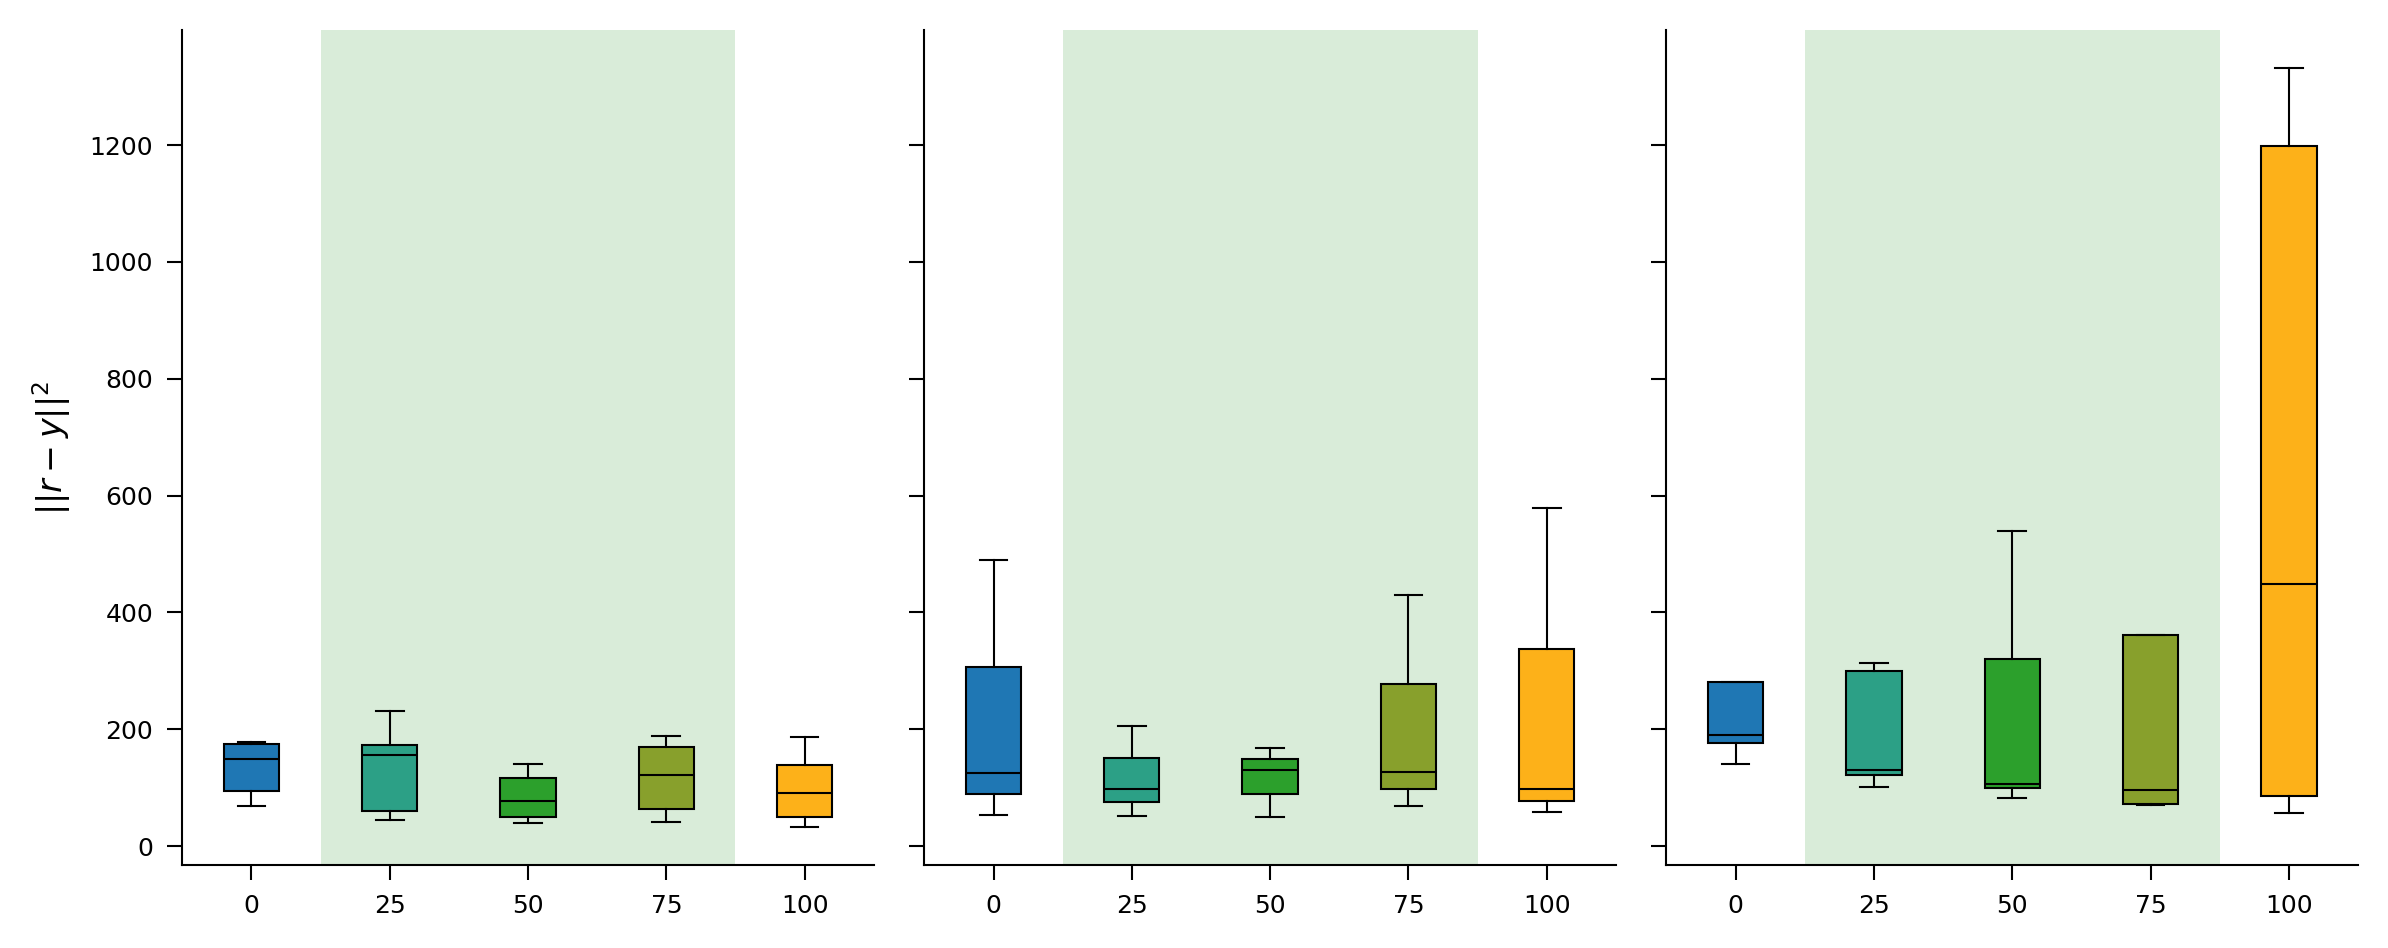

In [123]:
labels = conditions #slider : EMG
boxcolors = [colors['BLUE'],'#2ca086',colors['GREEN'],'#88a02c',colors['GOLD']]

def boxplot(ax,datas):
    bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('black')
    face0 = ax.axvspan(1.5,4.5, facecolor='green', alpha=0.15)

fig,axs = plt.subplots(1,3,figsize=(8,3.2),dpi=300,sharey=True)
ax = axs[0]
boxplot(ax,GROUP_A_RMSE)
ax.set_ylabel(r'$||r-y||^2$')

ax = axs[1]
boxplot(ax,GROUP_B_RMSE)

ax = axs[2]
boxplot(ax,GROUP_C_RMSE)

plt.tight_layout()
plt.show()

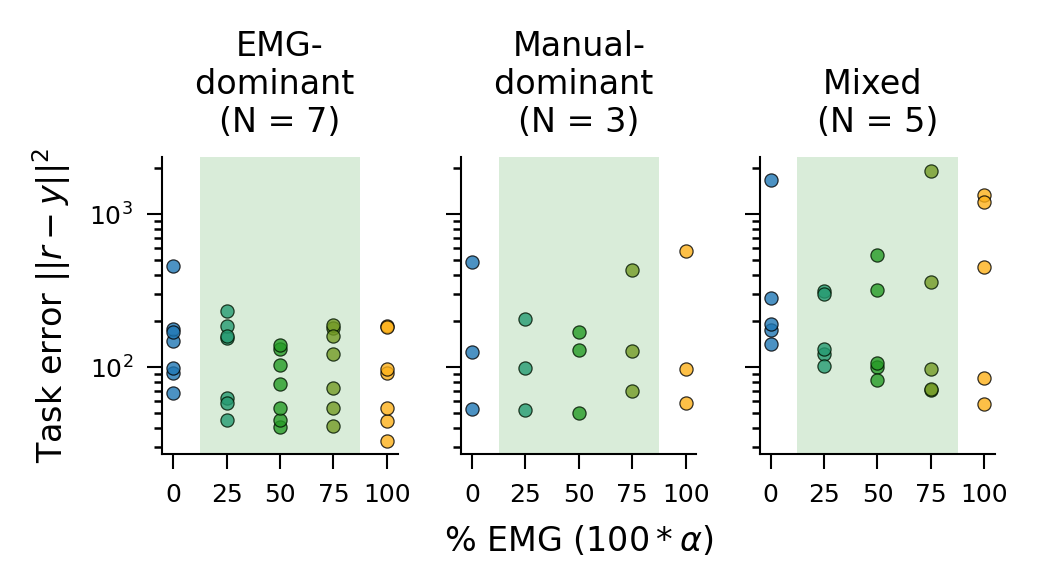

In [143]:
# labels = conditions  # list of 5 condition labels
boxcolors = [colors['BLUE'], '#2ca086', colors['GREEN'], '#88a02c', colors['GOLD']]
x_positions = np.arange(condition_num)

def scatterplot(ax, datas, color_list):
    """
    datas: (n_subjects, n_conditions)
    """
    n_conditions, n_subjects = len(datas),len(datas[0])
    for i in range(n_conditions):
        ax.scatter(np.full(n_subjects, x_positions[i]) , 
                   datas[i,:], 
                   color=color_list[i], 
                   edgecolor='k',
                   lw=0.3,
                   alpha=0.8,
                   s=10)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(labels, rotation=0)
    face0 = ax.axvspan(0.5,3.5, facecolor='green', alpha=0.15)

# --- Plot all three groups ---
fig, axs = plt.subplots(1, 3, figsize=(3.5,2), dpi=300, sharey=True)

ax = axs[0]
scatterplot(ax, np.array(GROUP_A_RMSE), boxcolors)
ax.set_ylabel('Task error '+r'$||r-y||^2$')
ax.set_yscale("log")

ax = axs[1]
scatterplot(ax, np.array(GROUP_B_RMSE), boxcolors)

ax = axs[2]
scatterplot(ax, np.array(GROUP_C_RMSE), boxcolors)

axs[0].set_title('EMG-\ndominant ''\n''(N = '+str(len(group_a))+')',fontsize=SMALL_SIZE)
axs[1].set_title('Manual-\ndominant ''\n''(N = '+str(len(group_b))+')',fontsize=SMALL_SIZE)
axs[2].set_title('Mixed ''\n''(N = '+str(len(group_c))+')',fontsize=SMALL_SIZE)
axs[1].set_xlabel(r'% EMG ($100*\alpha$)') #add x axis labels
plt.tight_layout()
plt.show()